In [2]:
import tifffile
import numpy as np


# In there upload the image you want split
# original_image = tifffile.imread(r'G:\Alexis_data\Project\FISH\input\Heart2_round3_DAPI_resliced-q1-z1_cp_masks.tif')

original_image = tifffile.imread(r'G:\Alexis_data\Project\FISH\input\Heart2_round2_DAPI_resliced.tif')

# Print image shape and data type
print(f"Image shape: {original_image.shape}")
print(f"Data type: {original_image.dtype}")

# Display basic statistics
print(f"Min value: {np.min(original_image)}")
print(f"Max value: {np.max(original_image)}")
print(f"Mean value: {np.mean(original_image)}")

Image shape: (944, 2115, 1857)
Data type: uint8
Min value: 0
Max value: 255
Mean value: 10.077238616710456


In [3]:
def segment_3d_with_coordinates(data, partition_d=2, partition_h=1, partition_w=2):
          
    """
    Segments 3D data and returns both segments and their coordinates
    
    Returns:
        main_segments: list of regular-sized segments
        main_coordinates: list of (d_start, d_end, h_start, h_end, w_start, w_end)
        leftover_segments: list of leftover segments
        leftover_coordinates: list of coordinates for leftover segments
    """
    depth, height, width = data.shape
    

    # Now perform the integer division
    n_depth = partition_d
    n_height = partition_h 
    n_width = partition_w

    depth_size = depth // partition_d
    height_size = height // partition_h
    width_size = width // partition_w

    main_segments = []
    main_coordinates = []
    leftover_segments = []
    leftover_coordinates = []
    
    # Extract main segments with coordinates
    for d in range(n_depth):
        for h in range(n_height):
            for w in range(n_width):
                d_start = d * depth_size
                d_end = (d + 1) * depth_size
                h_start = h * height_size
                h_end = (h + 1) * height_size
                w_start = w * width_size
                w_end = (w + 1) * width_size
                
                segment = data[d_start:d_end, h_start:h_end, w_start:w_end]
                main_segments.append(segment)
                main_coordinates.append((d_start, d_end, h_start, h_end, w_start, w_end))
    
    # Handle leftover in depth
    if depth % depth_size != 0:
        d_start = n_depth * depth_size
        d_end = depth
        h_end = height_size * n_height
        w_end = width_size * n_width
        
        leftover_d = data[d_start:d_end, :h_end, :w_end]
        if leftover_d.size > 0:
            leftover_segments.append(leftover_d)
            leftover_coordinates.append((d_start, d_end, 0, h_end, 0, w_end))
    
    # Handle leftover in height
    if height % height_size != 0:
        d_end = depth_size * n_depth
        h_start = height_size * n_height
        h_end = height
        w_end = width_size * n_width
        
        leftover_h = data[:d_end, h_start:h_end, :w_end]
        if leftover_h.size > 0:
            leftover_segments.append(leftover_h)
            leftover_coordinates.append((0, d_end, h_start, h_end, 0, w_end))
    
    # Handle leftover in width
    if width % width_size != 0:
        d_end = depth_size * n_depth
        h_end = height_size * n_height
        w_start = width_size * n_width
        w_end = width
        
        leftover_w = data[:d_end, :h_end, w_start:w_end]
        if leftover_w.size > 0:
            leftover_segments.append(leftover_w)
            leftover_coordinates.append((0, d_end, 0, h_end, w_start, w_end))
    
    return main_segments, main_coordinates, leftover_segments, leftover_coordinates

In [5]:
# call the function
main_segments, main_coords, leftover_segments, leftover_coords = segment_3d_with_coordinates(
    original_image,
    partition_d = 2,
    partition_h = 1,
    partition_w = 2,
    )

# # Access main segments and their coordinates
# for segment, coords in zip(main_segments, main_coords):
#     d_start, d_end, h_start, h_end, w_start, w_end = coords
#     print(f"Segment shape: {segment.shape}")
#     print(f"Coordinates: ({d_start}:{d_end}, {h_start}:{h_end}, {w_start}:{w_end})")
  

In [6]:
# Print results
print(f"Original data shape: {original_image.shape}")
print(f"Number of main segments: {len(main_segments)}")
print("\nMain segment coordinates:")
for i, coords in enumerate(main_coords):
    print(f"Segment {i}: {coords}")

print("\nLeftover segment coordinates:")
for i, coords in enumerate(leftover_coords):
    print(f"Leftover {i}: {coords}")

Original data shape: (944, 2115, 1857)
Number of main segments: 4

Main segment coordinates:
Segment 0: (0, 472, 0, 2115, 0, 928)
Segment 1: (0, 472, 0, 2115, 928, 1856)
Segment 2: (472, 944, 0, 2115, 0, 928)
Segment 3: (472, 944, 0, 2115, 928, 1856)

Leftover segment coordinates:
Leftover 0: (0, 944, 0, 2115, 1856, 1857)


In [7]:
def adjust_segments(main_coords, leftover_coords, image_shape, overlap_percentage = 0.1/2):
    """
    Adjust the segment coordinates with specified expansion or contraction.

    Parameters:
        main_coords (list of tuples): Original main segment coordinates.
        leftover_coords (list of tuples): Original leftover segment coordinates.
        image_shape (tuple): Shape of the original image as (z, y, x).

    Returns:
        adjusted_main_coords (list of tuples): Adjusted main segment coordinates.
        adjusted_leftover_coords (list of tuples): Adjusted leftover segment coordinates.
    """
    z_max, y_max, x_max = image_shape

    z_overlap = int(overlap_percentage * z_max)
    y_overlap = int(overlap_percentage * y_max)
    x_overlap = int(overlap_percentage * x_max)

    # Adjust main segment coordinates
    adjusted_main_coords = []
    for i, (z_start, z_end, y_start, y_end, x_start, x_end) in enumerate(main_coords):
        z_start_adj = max(0, z_start - z_overlap)
        z_end_adj = min(z_max, z_end + z_overlap)
        y_start_adj = max(0, y_start - y_overlap)
        y_end_adj = min(y_max, y_end + y_overlap)
        x_start_adj = max(0, x_start - x_overlap)
        x_end_adj = min(x_max, x_end + x_overlap)

        # If boundary constraints apply, adjust
        if z_end_adj == z_max:
            z_end_adj = z_max
        if y_end_adj == y_max:
            y_end_adj = y_max
        if x_end_adj == x_max:
            x_end_adj = x_max

        adjusted_main_coords.append((z_start_adj, z_end_adj, y_start_adj, y_end_adj, x_start_adj, x_end_adj))

    # Adjust leftover segment coordinates
    adjusted_leftover_coords = []
    for i, (z_start, z_end, y_start, y_end, x_start, x_end) in enumerate(leftover_coords):
        # Assume leftover segments retain original coordinates but apply boundaries
        z_start_adj = z_start
        z_end_adj = z_max if z_end == z_max else z_end
        y_start_adj = y_start
        y_end_adj = y_max if y_end == y_max else y_end
        x_start_adj = x_start
        x_end_adj = x_end

        adjusted_leftover_coords.append((z_start_adj, z_end_adj, y_start_adj, y_end_adj, x_start_adj, x_end_adj))

    return adjusted_main_coords, adjusted_leftover_coords


In [8]:
original_image_shape = original_image.shape

adjusted_main, adjusted_leftover = adjust_segments(main_coords, leftover_coords, original_image_shape)

# Print adjusted results
print("Adjusted Main Segment Coordinates:")
for i, coords in enumerate(adjusted_main):
    print(f"Segment {i}: {coords}")

print("\nAdjusted Leftover Segment Coordinates:")
for i, coords in enumerate(adjusted_leftover):
    print(f"Leftover {i}: {coords}")


Adjusted Main Segment Coordinates:
Segment 0: (0, 519, 0, 2115, 0, 1020)
Segment 1: (0, 519, 0, 2115, 836, 1857)
Segment 2: (425, 944, 0, 2115, 0, 1020)
Segment 3: (425, 944, 0, 2115, 836, 1857)

Adjusted Leftover Segment Coordinates:
Leftover 0: (0, 944, 0, 2115, 1856, 1857)


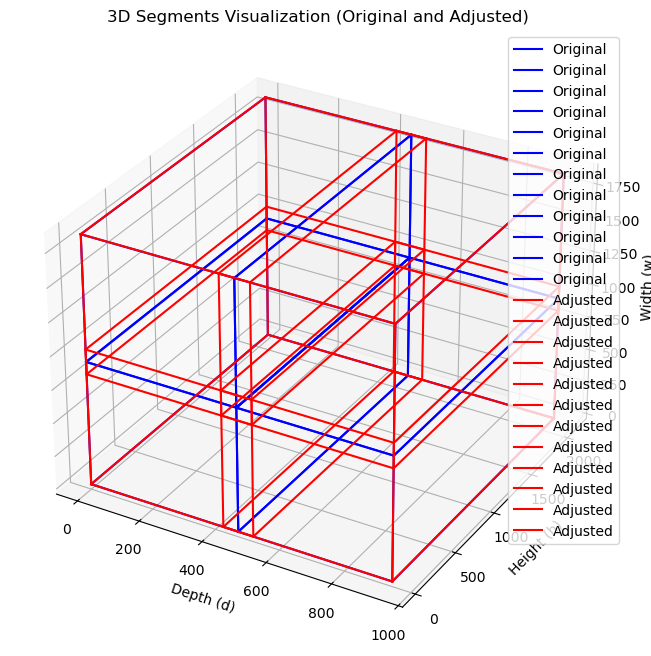

In [9]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Draw original segments in blue
for coords in main_coords:
    d_start, d_end, h_start, h_end, w_start, w_end = coords
    
    edges = [
        ((d_start, h_start, w_start), (d_start, h_start, w_end)),
        ((d_start, h_start, w_start), (d_start, h_end, w_start)),
        ((d_start, h_start, w_start), (d_end, h_start, w_start)),
        ((d_start, h_end, w_start), (d_start, h_end, w_end)),
        ((d_start, h_end, w_start), (d_end, h_end, w_start)),
        ((d_start, h_start, w_end), (d_start, h_end, w_end)),
        ((d_start, h_start, w_end), (d_end, h_start, w_end)),
        ((d_end, h_start, w_start), (d_end, h_start, w_end)),
        ((d_end, h_start, w_start), (d_end, h_end, w_start)),
        ((d_start, h_end, w_end), (d_end, h_end, w_end)),
        ((d_end, h_end, w_start), (d_end, h_end, w_end)),
        ((d_end, h_start, w_end), (d_end, h_end, w_end))
    ]
    
    for start, end in edges:
        x_vals = [start[0], end[0]]
        y_vals = [start[1], end[1]]
        z_vals = [start[2], end[2]]
        ax.plot(x_vals, y_vals, z_vals, color='b', label='Original' if coords == main_coords[0] else "")

# Draw adjusted segments in red
for coords in adjusted_main:
    d_start, d_end, h_start, h_end, w_start, w_end = coords
    
    edges = [
        ((d_start, h_start, w_start), (d_start, h_start, w_end)),
        ((d_start, h_start, w_start), (d_start, h_end, w_start)),
        ((d_start, h_start, w_start), (d_end, h_start, w_start)),
        ((d_start, h_end, w_start), (d_start, h_end, w_end)),
        ((d_start, h_end, w_start), (d_end, h_end, w_start)),
        ((d_start, h_start, w_end), (d_start, h_end, w_end)),
        ((d_start, h_start, w_end), (d_end, h_start, w_end)),
        ((d_end, h_start, w_start), (d_end, h_start, w_end)),
        ((d_end, h_start, w_start), (d_end, h_end, w_start)),
        ((d_start, h_end, w_end), (d_end, h_end, w_end)),
        ((d_end, h_end, w_start), (d_end, h_end, w_end)),
        ((d_end, h_start, w_end), (d_end, h_end, w_end))
    ]
    
    for start, end in edges:
        x_vals = [start[0], end[0]]
        y_vals = [start[1], end[1]]
        z_vals = [start[2], end[2]]
        ax.plot(x_vals, y_vals, z_vals, color='r', label='Adjusted' if coords == adjusted_main[0] else "")

# Set labels and show plot
ax.set_xlabel('Depth (d)')
ax.set_ylabel('Height (h)')
ax.set_zlabel('Width (w)')
ax.set_title('3D Segments Visualization (Original and Adjusted)')
ax.legend()
plt.show()


In [48]:
import numpy as np
import tifffile as tiff

# Load the 3D TIFF image
image = original_image

# # List of coordinates
# adjusted_main = [
#     (0, 200, 0, 682, 0, 612),
#     (0, 200, 0, 682, 412, 1024),
#     (0, 200, 482, 1164, 0, 612),
#     (0, 200, 482, 1164, 412, 1024),
#     (190, 390, 0, 682, 0, 612),
#     (190, 390, 0, 682, 412, 1024),
#     (190, 390, 482, 1164, 0, 612),
#     (190, 390, 482, 1164, 412, 1024)
# ]

# Process each crop
cropped_images = []
for i, (z_start, z_end, y_start, y_end, x_start, x_end) in enumerate(adjusted_main):
    print(f"Cropping section {i}...")
    cropped = image[z_start:z_end, y_start:y_end, x_start:x_end]
    cropped_images.append(cropped)
    # Save each cropped section if needed
    tiff.imwrite(f'output\H2R2_test\Heart2_round2_cropped_section_{i}.tif', cropped)

print(f"{len(cropped_images)} cropped images saved successfully.")


Cropping section 0...
Cropping section 1...
Cropping section 2...
Cropping section 3...
Cropping section 4...
Cropping section 5...
Cropping section 6...
Cropping section 7...
Cropping section 8...
Cropping section 9...
Cropping section 10...
Cropping section 11...
Cropping section 12...
Cropping section 13...
Cropping section 14...
Cropping section 15...
Cropping section 16...
Cropping section 17...
Cropping section 18...
Cropping section 19...
Cropping section 20...
Cropping section 21...
Cropping section 22...
Cropping section 23...
Cropping section 24...
Cropping section 25...


KeyboardInterrupt: 